In [32]:
import requests
import string
import random
import json
import re
import io
import cv2
import sys

from PIL import Image
from io import BytesIO
import urllib.request as urllib

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

!pip install -qq python-resize-image
from resizeimage import resizeimage

from skimage.color import rgb2gray
from keras.models import load_model

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
CLIENT_ID    = '868u2fys86k0vp'
CLIENT_SECRET = 'YfkAAXQkULtINTqY'
REDIRECT_URI = 'http://localhost/project-image'

In [3]:
# Request authentication URL
auth_params = {'response_type': 'code',
               'client_id': CLIENT_ID,
               'redirect_uri': REDIRECT_URI,
               'scope': 'r_liteprofile,r_emailaddress'}

html = requests.get("https://www.linkedin.com/oauth/v2/authorization",
                    params = auth_params)

# Print the link to the approval page
print(html.url)

https://www.linkedin.com/uas/login?session_redirect=%2Foauth%2Fv2%2Flogin-success%3Fapp_id%3D87475046%26auth_type%3DAC%26flow%3D%257B%2522scope%2522%253A%2522r_liteprofile%252Cr_emailaddress%2522%252C%2522creationTime%2522%253A1606102354834%252C%2522appId%2522%253A87475046%252C%2522authorizationType%2522%253A%2522OAUTH2_AUTHORIZATION_CODE%2522%252C%2522redirectUri%2522%253A%2522http%253A%252F%252Flocalhost%252Fproject-image%2522%252C%2522currentStage%2522%253A%2522LOGIN_SUCCESS%2522%252C%2522currentSubStage%2522%253A0%252C%2522authFlowName%2522%253A%2522generic-permission-list%2522%257D&fromSignIn=1&trk=oauth&cancel_redirect=%2Foauth%2Fv2%2Flogin-cancel%3Fapp_id%3D87475046%26auth_type%3DAC%26flow%3D%257B%2522scope%2522%253A%2522r_liteprofile%252Cr_emailaddress%2522%252C%2522creationTime%2522%253A1606102354834%252C%2522appId%2522%253A87475046%252C%2522authorizationType%2522%253A%2522OAUTH2_AUTHORIZATION_CODE%2522%252C%2522redirectUri%2522%253A%2522http%253A%252F%252Flocalhost%252Fprojec

In [5]:
AUTH_CODE = 'AQRB3gFixnx9Ukyf0sSbBe-bYrdCHWoc5v_0qbUceocbg51lYXaDalntLwp4KKUxLQlXsDvsbAg3jwLXConPg901gRWOJGQT57X62o5OX1vYREIlYyfSIdtu7Q3q0Zh9cREmUE5ALgN6K9pBpNlg7-hF_ZMNFWFOs_8YuIrlmiJY34qnnyEGJUzVX6TIUA'

ACCESS_TOKEN_URL = 'https://www.linkedin.com/oauth/v2/accessToken'

qd = {'grant_type': 'authorization_code',
      'code': AUTH_CODE,
      'redirect_uri': REDIRECT_URI,
      'client_id': CLIENT_ID,
      'client_secret': CLIENT_SECRET}

response = requests.post(ACCESS_TOKEN_URL, data=qd, timeout=60)

response = response.json()

access_token = response['access_token']

print ("Access Token:", access_token)
print ("Expires in (seconds):", response['expires_in'])

Access Token: AQU04PdlaxfAhAdHhUxpF5A9P_mu5uqn1546BzEs2ph6np8KxXY9juHONlIQcE4i2mfHXyQrBQQOX_jD8z3eyTfFRW0ZqhDwDMRRtnSJ5f-7GeW7kLuV-zq83_8tnZOU6i4HVirEhMhxRQN4KTTaKmRjHvZiJEc3NKiKVOXnJboGmHoBYqGRMkOvyYVYseRQviAii-cQURjdDcM1WeToi8gQhMEkWcTYihPSBiryI4uy9T0xviuZquRK7J8RmkIPoVmYcJsUv9ak9-qaq_z71ifOhsL7_edi-Gj7AVL08J5N5D8raClq0Ugyz6nSyPvAZ0k_aG51050_0xSgFaODCoMUDa00EQ
Expires in (seconds): 5183999


In [6]:
params = {'oauth2_access_token': access_token}

response = requests.get('https://api.linkedin.com/v2/me?projection=(profilePicture(displayImage~digitalmediaAsset:playableStreams))', params = params)

with open('linkedin_profpic.json', mode = 'w') as file:
  file.write(json.dumps(response.json(), indent = 4))

In [7]:
with open('/content/linkedin_profpic.json', mode = 'r', encoding = 'utf-8') as file:
  response_list = (json.load(file)) 

elements_tag = str(response_list['profilePicture']['displayImage~']['elements'])

def image_url_fetch(line):
  regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
  url = re.findall(regex,line)       
  return [x[0] for x in url] 

image_url = image_url_fetch(elements_tag)[1]

In [8]:
def image_download(url, ext):
  image = Image.open(urllib.urlopen(url))

  fp = io.BytesIO()
  format = Image.registered_extensions()['.'+ext]
  image.save(fp, format)
  return fp.getvalue()

jpg = image_download(image_url, "jpg")

with open('linkedin_image.jpg', 'wb') as file:
  file.write(jpg)

In [27]:
def image_bounding_box(image):
  cascPath = "/content/haarcascade_frontalface_default.xml"
  faceCascade = cv2.CascadeClassifier(cascPath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Detect faces in the image
  faces = faceCascade.detectMultiScale(
      gray,
      scaleFactor=1.1,
      minNeighbors=5,
      minSize=(30, 30))

  # Draw a rectangle around the faces
  for (x, y, w, h) in faces:
      cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

  # Compute Face Proportion   
  face_size = (x+w) * (y+h)
  img_size = image.shape[0] * image.shape[1]
  proportion = round((face_size/img_size)*100, 2)

  if proportion < 50:
    print("Face : too Small (", proportion, '%)')
  else:
    if proportion <= 60:
       print("Face : OK! (", proportion, '%)')
    else:
      print("Face : too BIG (", proportion, '%)')
  return (x, y, w, h)

In [36]:
# Blur Background
def image_blur_bg(image, x, y, w, h):
  blur = cv2.GaussianBlur(image, (21, 21), 0)
  mask = np.zeros((200,200, 3), dtype=np.uint8)
  #mask = np.zeros((1092, 1200, 3), dtype=np.uint8)
  mask = cv2.rectangle(mask, (x,y), (x+w,y+h), (255, 255, 255), -1)
  img_blur = np.where(mask==(255, 255, 255), image, blur)

  roi = image[y:y+h, x:x+w]
  cv2.imwrite("linkedin_roi.jpg", roi)
  return img_blur

In [29]:
def image_resize(image):
  # Image Resize
  with open(image, 'r+b')as f:
  #with open('sad.jpg', 'r+b')as f:
    with Image.open(f) as image:
      resize_img = resizeimage.resize_cover(image, [48, 48])
      resize_img.save('resize_image.jpg', image.format)

In [34]:
emotions = ['happy', 'sad', 'neutral']

def emotion_predict(resize_image):
  gray_img = rgb2gray(resize_image)
  gray_img = np.array([np.reshape(gray_img, (48,48))])

  model = load_model("/content/model_happy.h5")
  predicted_class = np.argmax(model.predict(gray_img))

  print('Emotion : ', emotions[predicted_class])

Face : OK! ( 55.38 %)
Emotion :  neutral


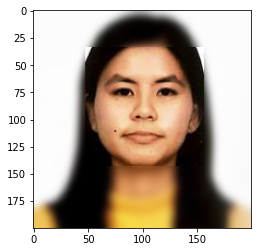

In [37]:
img_original = mpimg.imread('/content/linkedin_image.jpg')
#img_original = mpimg.imread('/content/happy.jpg')
x, y, w, h = image_bounding_box(img_original)

img_original = mpimg.imread('/content/linkedin_image.jpg')
#img_original = mpimg.imread('/content/happy.jpg')
img_blur = image_blur_bg(img_original, x, y, w, h)

image_roi = 'linkedin_roi.jpg'
image_resize(image_roi)

img_resize = mpimg.imread('/content/resize_image.jpg')
emotion_predict(img_resize)

imgplot = plt.imshow(img_blur)
plt.show()